In [1]:
#notebook for neural style transfer


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./data/images/neural-style/picasso.jpg")
content_img = image_loader("./data/images/neural-style/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [4]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./data/images/neural-style/picasso.jpg")
content_img = image_loader("./data/images/neural-style/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

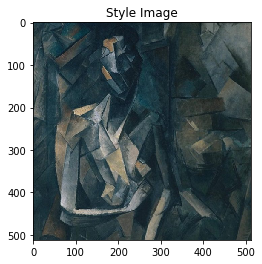

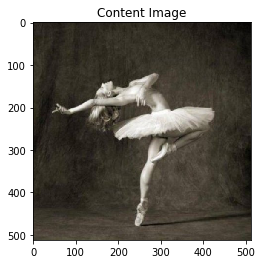

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        #print('Content Loss')
        #print('target shape: %s'%str(self.target.shape))
        #print('input shape: %s'%str(input.shape))
        self.loss = F.mse_loss(input, self.target)
        return input

In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1,
                       content_layers = content_layers_default,style_layers=style_layers_default):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, 
        content_layers = content_layers, style_layers = style_layers)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

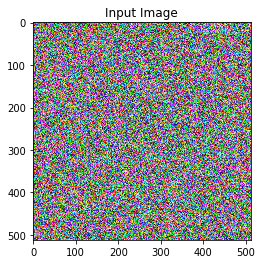

In [14]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

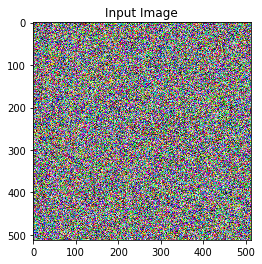

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 83.872360 Content Loss: 11.844033

run [100]:
Style Loss : 22.808079 Content Loss: 9.459619

run [150]:
Style Loss : 4.940575 Content Loss: 7.401252

run [200]:
Style Loss : 1.931361 Content Loss: 5.782865

run [250]:
Style Loss : 1.274926 Content Loss: 4.811395

run [300]:
Style Loss : 0.966865 Content Loss: 4.151784

run [350]:
Style Loss : 0.741612 Content Loss: 3.730889

run [400]:
Style Loss : 0.574891 Content Loss: 3.421810

run [450]:
Style Loss : 0.445124 Content Loss: 3.187051

run [500]:
Style Loss : 0.359122 Content Loss: 3.019421

run [550]:
Style Loss : 0.298817 Content Loss: 2.882713

run [600]:
Style Loss : 0.257257 Content Loss: 2.774559

run [650]:
Style Loss : 0.225228 Content Loss: 2.684813

run [700]:
Style Loss : 0.203102 Content Loss: 2.611341

run [750]:
Style Loss : 0.187540 Content Loss: 2.548841

run [800]:
Style Loss : 0.173148 Content Loss: 2.499627

run [850]:
Style Loss : 0.163794 Content Loss: 2.457605

run [900]:
Style Loss : 0.156

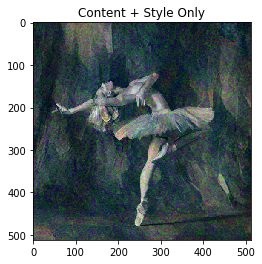

In [29]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=1500)

plt.figure()
imshow(output, title='Content + Style Only')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

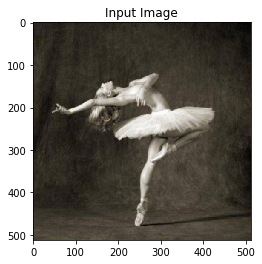

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 3.918112 Content Loss: 4.142098

run [100]:
Style Loss : 1.143173 Content Loss: 3.040681

run [150]:
Style Loss : 0.719581 Content Loss: 2.665734

run [200]:
Style Loss : 0.482202 Content Loss: 2.503453

run [250]:
Style Loss : 0.348364 Content Loss: 2.413106

run [300]:
Style Loss : 0.268121 Content Loss: 2.359993



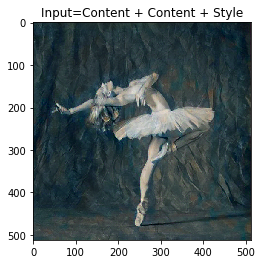

In [76]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Input=Content + Content + Style')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

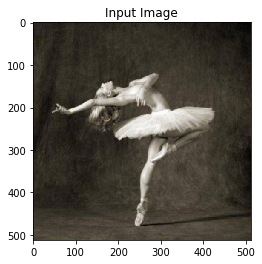

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 3.799055 Content Loss: 0.000000

run [100]:
Style Loss : 0.907798 Content Loss: 0.000000

run [150]:
Style Loss : 0.489106 Content Loss: 0.000000

run [200]:
Style Loss : 0.284833 Content Loss: 0.000000

run [250]:
Style Loss : 0.171470 Content Loss: 0.000000

run [300]:
Style Loss : 0.104742 Content Loss: 0.000000



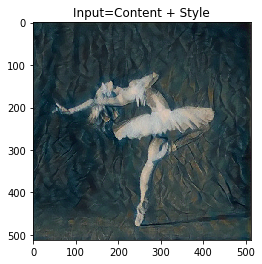

In [77]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, content_weight = 0)

plt.figure()
imshow(output, title='Input=Content + Style')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

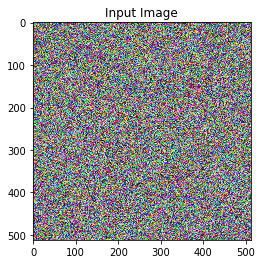

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.000000 Content Loss: 0.853297

run [100]:
Style Loss : 0.000000 Content Loss: 0.422143

run [150]:
Style Loss : 0.000000 Content Loss: 0.261759

run [200]:
Style Loss : 0.000000 Content Loss: 0.188612

run [250]:
Style Loss : 0.000000 Content Loss: 0.138288

run [300]:
Style Loss : 0.000000 Content Loss: 0.095806

run [350]:
Style Loss : 0.000000 Content Loss: 0.061965

run [400]:
Style Loss : 0.000000 Content Loss: 0.039253

run [450]:
Style Loss : 0.000000 Content Loss: 0.039492

run [500]:
Style Loss : 0.000000 Content Loss: 0.017022

run [550]:
Style Loss : 0.000000 Content Loss: 0.010788

run [600]:
Style Loss : 0.000000 Content Loss: 0.007768

run [650]:
Style Loss : 0.000000 Content Loss: 0.006766

run [700]:
Style Loss : 0.000000 Content Loss: 0.004471

run [750]:
Style Loss : 0.000000 Content Loss: 0.003554

run [800]:
Style Loss : 0.000000 Content Loss: 0.003192

run [850]:
Style Loss : 0.000000 Content Loss: 0.002502

run [900]:
Style Loss : 0.000000

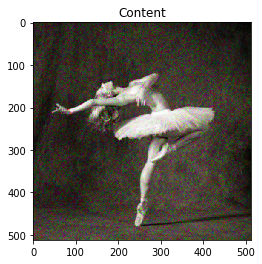

In [78]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight = 0,num_steps=1000)

plt.figure()
imshow(output, title='Content')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

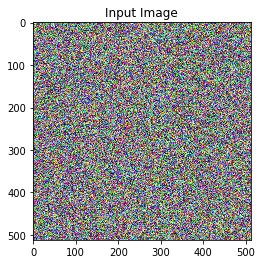

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 84.294182 Content Loss: 0.000000

run [100]:
Style Loss : 23.123894 Content Loss: 0.000000

run [150]:
Style Loss : 4.632973 Content Loss: 0.000000

run [200]:
Style Loss : 1.551737 Content Loss: 0.000000

run [250]:
Style Loss : 0.926659 Content Loss: 0.000000

run [300]:
Style Loss : 0.635123 Content Loss: 0.000000

run [350]:
Style Loss : 0.443661 Content Loss: 0.000000

run [400]:
Style Loss : 0.309444 Content Loss: 0.000000

run [450]:
Style Loss : 0.221085 Content Loss: 0.000000

run [500]:
Style Loss : 0.163065 Content Loss: 0.000000

run [550]:
Style Loss : 0.121462 Content Loss: 0.000000

run [600]:
Style Loss : 0.092747 Content Loss: 0.000000

run [650]:
Style Loss : 0.070586 Content Loss: 0.000000

run [700]:
Style Loss : 0.054262 Content Loss: 0.000000

run [750]:
Style Loss : 0.041943 Content Loss: 0.000000

run [800]:
Style Loss : 0.032752 Content Loss: 0.000000

run [850]:
Style Loss : 0.026211 Content Loss: 0.000000

run [900]:
Style Loss : 0.0212

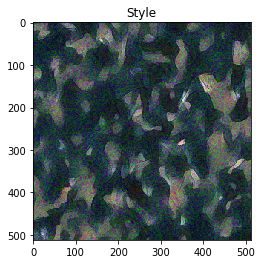

In [79]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, content_weight = 0,num_steps=1000)

plt.figure()
imshow(output, title='Style')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

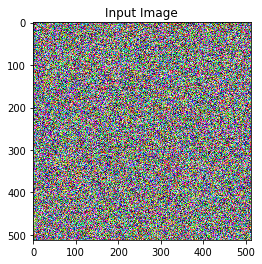

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.000000 Content Loss: 0.574204

run [100]:
Style Loss : 0.000000 Content Loss: 0.190138

run [150]:
Style Loss : 0.000000 Content Loss: 0.108203

run [200]:
Style Loss : 0.000000 Content Loss: 0.071542

run [250]:
Style Loss : 0.000000 Content Loss: 0.048236

run [300]:
Style Loss : 0.000000 Content Loss: 0.033540

run [350]:
Style Loss : 0.000000 Content Loss: 0.024528

run [400]:
Style Loss : 0.000000 Content Loss: 0.018886

run [450]:
Style Loss : 0.000000 Content Loss: 0.015376

run [500]:
Style Loss : 0.000000 Content Loss: 0.013327

run [550]:
Style Loss : 0.000000 Content Loss: 0.012060

run [600]:
Style Loss : 0.000000 Content Loss: 0.011195

run [650]:
Style Loss : 0.000000 Content Loss: 0.010526

run [700]:
Style Loss : 0.000000 Content Loss: 0.009995

run [750]:
Style Loss : 0.000000 Content Loss: 0.022677

run [800]:
Style Loss : 0.000000 Content Loss: 0.010123

run [850]:
Style Loss : 0.000000 Content Loss: 0.008762

run [900]:
Style Loss : 0.000000

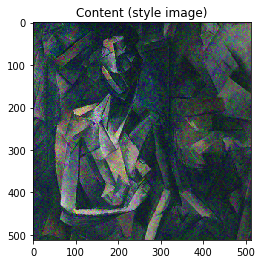

In [81]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            style_img, style_img, input_img, style_weight = 0,num_steps=1000)

plt.figure()
imshow(output, title='Content (style image)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

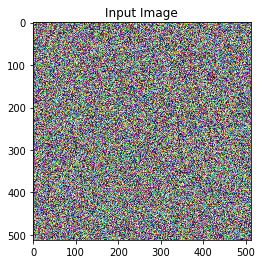

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.000000 Content Loss: 2.422940

run [100]:
Style Loss : 0.000000 Content Loss: 1.134987

run [150]:
Style Loss : 0.000000 Content Loss: 0.747481

run [200]:
Style Loss : 0.000000 Content Loss: 0.561054

run [250]:
Style Loss : 0.000000 Content Loss: 0.452433

run [300]:
Style Loss : 0.000000 Content Loss: 0.382070

run [350]:
Style Loss : 0.000000 Content Loss: 0.331781

run [400]:
Style Loss : 0.000000 Content Loss: 0.294047

run [450]:
Style Loss : 0.000000 Content Loss: 0.264775

run [500]:
Style Loss : 0.000000 Content Loss: 0.241476

run [550]:
Style Loss : 0.000000 Content Loss: 0.222415

run [600]:
Style Loss : 0.000000 Content Loss: 0.207464

run [650]:
Style Loss : 0.000000 Content Loss: 0.194688

run [700]:
Style Loss : 0.000000 Content Loss: 0.183025

run [750]:
Style Loss : 0.000000 Content Loss: 0.173420

run [800]:
Style Loss : 0.000000 Content Loss: 0.165232

run [850]:
Style Loss : 0.000000 Content Loss: 0.157287

run [900]:
Style Loss : 0.000000

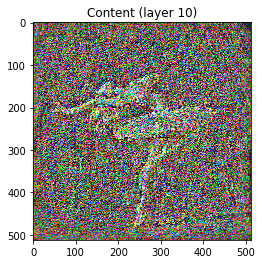

In [98]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight = 0,num_steps=2000,content_layers=['conv_10'])

plt.figure()
imshow(output, title='Content (layer 10)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

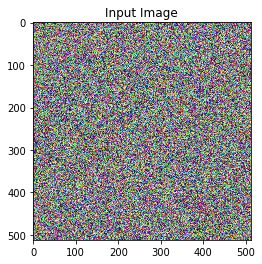

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 81.726379 Content Loss: 0.475698

run [100]:
Style Loss : 23.132763 Content Loss: 0.376454

run [150]:
Style Loss : 4.693799 Content Loss: 0.342956

run [200]:
Style Loss : 1.600182 Content Loss: 0.332885

run [250]:
Style Loss : 0.948283 Content Loss: 0.329272

run [300]:
Style Loss : 0.658653 Content Loss: 0.326448

run [350]:
Style Loss : 0.461422 Content Loss: 0.323539

run [400]:
Style Loss : 0.322810 Content Loss: 0.320251

run [450]:
Style Loss : 0.228944 Content Loss: 0.317124

run [500]:
Style Loss : 0.167777 Content Loss: 0.313870

run [550]:
Style Loss : 0.128121 Content Loss: 0.310391

run [600]:
Style Loss : 0.099110 Content Loss: 0.306096

run [650]:
Style Loss : 0.076815 Content Loss: 0.301148

run [700]:
Style Loss : 0.059627 Content Loss: 0.295506

run [750]:
Style Loss : 0.047057 Content Loss: 0.289527

run [800]:
Style Loss : 0.037712 Content Loss: 0.283265

run [850]:
Style Loss : 0.030496 Content Loss: 0.276392

run [900]:
Style Loss : 0.0257

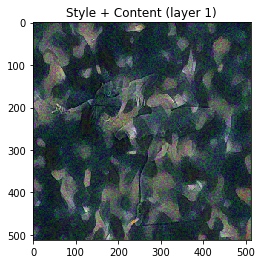

In [85]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1000,content_layers=['conv_1'])

plt.figure()
imshow(output, title='Style + Content (layer 1)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

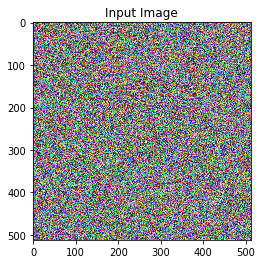

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 81.805305 Content Loss: 2.579185

run [100]:
Style Loss : 22.515421 Content Loss: 2.449935

run [150]:
Style Loss : 4.683291 Content Loss: 2.352885

run [200]:
Style Loss : 1.661981 Content Loss: 2.240195

run [250]:
Style Loss : 1.010961 Content Loss: 2.107546

run [300]:
Style Loss : 0.720800 Content Loss: 1.966757

run [350]:
Style Loss : 0.535913 Content Loss: 1.827948

run [400]:
Style Loss : 0.402902 Content Loss: 1.709196

run [450]:
Style Loss : 0.299750 Content Loss: 1.611168

run [500]:
Style Loss : 0.229473 Content Loss: 1.525810

run [550]:
Style Loss : 0.180268 Content Loss: 1.457024

run [600]:
Style Loss : 0.146131 Content Loss: 1.398871

run [650]:
Style Loss : 0.121726 Content Loss: 1.346942

run [700]:
Style Loss : 0.102855 Content Loss: 1.303383

run [750]:
Style Loss : 0.088649 Content Loss: 1.265294

run [800]:
Style Loss : 0.076881 Content Loss: 1.232208

run [850]:
Style Loss : 0.067700 Content Loss: 1.203434

run [900]:
Style Loss : 0.0600

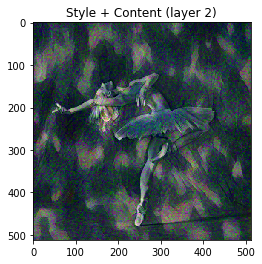

In [91]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1000,content_layers=['conv_2'])

plt.figure()
imshow(output, title='Style + Content (layer 2)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

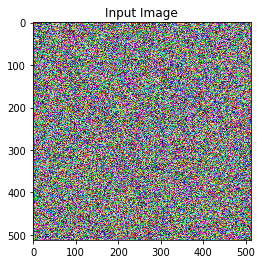

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 81.317429 Content Loss: 6.242533

run [100]:
Style Loss : 22.732988 Content Loss: 5.657219

run [150]:
Style Loss : 4.564053 Content Loss: 4.907149

run [200]:
Style Loss : 1.699378 Content Loss: 4.168031

run [250]:
Style Loss : 1.131954 Content Loss: 3.550655

run [300]:
Style Loss : 0.843655 Content Loss: 3.108367

run [350]:
Style Loss : 0.637671 Content Loss: 2.792668

run [400]:
Style Loss : 0.482322 Content Loss: 2.561475

run [450]:
Style Loss : 0.370512 Content Loss: 2.388865

run [500]:
Style Loss : 0.292575 Content Loss: 2.254086

run [550]:
Style Loss : 0.235039 Content Loss: 2.152709

run [600]:
Style Loss : 0.196421 Content Loss: 2.068193

run [650]:
Style Loss : 0.167406 Content Loss: 1.998822

run [700]:
Style Loss : 0.145164 Content Loss: 1.942630

run [750]:
Style Loss : 0.129576 Content Loss: 1.898849

run [800]:
Style Loss : 0.116448 Content Loss: 1.859736

run [850]:
Style Loss : 0.107029 Content Loss: 1.826030

run [900]:
Style Loss : 0.0995

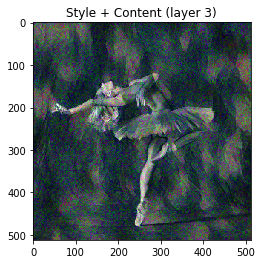

In [87]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1000,content_layers=['conv_3'])

plt.figure()
imshow(output, title='Style + Content (layer 3)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

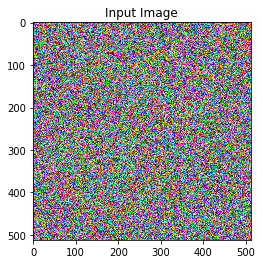

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 86.192230 Content Loss: 20.450871

run [100]:
Style Loss : 23.399237 Content Loss: 13.415640

run [150]:
Style Loss : 5.379509 Content Loss: 9.498021

run [200]:
Style Loss : 2.496870 Content Loss: 7.238186

run [250]:
Style Loss : 1.806005 Content Loss: 6.049602

run [300]:
Style Loss : 1.428475 Content Loss: 5.272752

run [350]:
Style Loss : 1.161250 Content Loss: 4.734105

run [400]:
Style Loss : 0.971157 Content Loss: 4.351057

run [450]:
Style Loss : 0.833996 Content Loss: 4.060216

run [500]:
Style Loss : 0.740606 Content Loss: 3.839710

run [550]:
Style Loss : 0.671195 Content Loss: 3.647215

run [600]:
Style Loss : 0.628634 Content Loss: 3.498730

run [650]:
Style Loss : 0.596132 Content Loss: 3.379061

run [700]:
Style Loss : 0.569809 Content Loss: 3.278933

run [750]:
Style Loss : 0.551807 Content Loss: 3.193367

run [800]:
Style Loss : 0.537223 Content Loss: 3.121259

run [850]:
Style Loss : 0.525375 Content Loss: 3.063339

run [900]:
Style Loss : 0.51

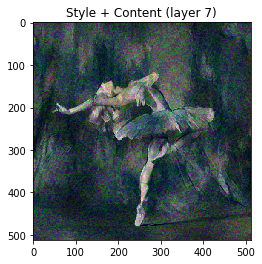

In [90]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1000,content_layers=['conv_7'])

plt.figure()
imshow(output, title='Style + Content (layer 7)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

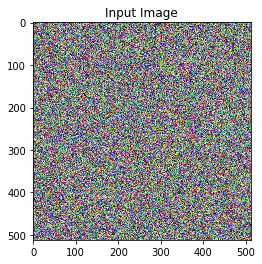

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 85.068520 Content Loss: 11.045874

run [100]:
Style Loss : 23.107244 Content Loss: 6.940959

run [150]:
Style Loss : 4.886645 Content Loss: 4.523015

run [200]:
Style Loss : 2.042803 Content Loss: 3.134567

run [250]:
Style Loss : 1.376474 Content Loss: 2.476425

run [300]:
Style Loss : 1.023061 Content Loss: 2.078641

run [350]:
Style Loss : 0.776171 Content Loss: 1.800735

run [400]:
Style Loss : 0.602090 Content Loss: 1.603022

run [450]:
Style Loss : 0.473081 Content Loss: 1.449114

run [500]:
Style Loss : 0.383631 Content Loss: 1.327398

run [550]:
Style Loss : 0.320352 Content Loss: 1.230743

run [600]:
Style Loss : 0.277230 Content Loss: 1.153038

run [650]:
Style Loss : 0.244293 Content Loss: 1.087443

run [700]:
Style Loss : 0.219019 Content Loss: 1.031735

run [750]:
Style Loss : 0.199625 Content Loss: 0.984645

run [800]:
Style Loss : 0.183446 Content Loss: 0.945563

run [850]:
Style Loss : 0.170443 Content Loss: 0.911539

run [900]:
Style Loss : 0.159

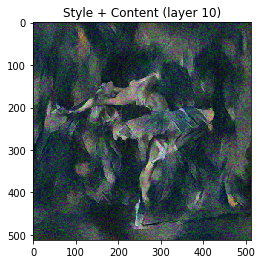

In [89]:
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1000,content_layers=['conv_10'])

plt.figure()
imshow(output, title='Style + Content (layer 10)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

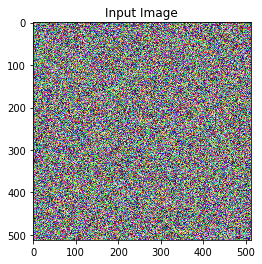

Building the style transfer model..
Optimizing..


/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 82.496895 Content Loss: 1.167333

run [100]:
Style Loss : 23.456846 Content Loss: 0.680242

run [150]:
Style Loss : 4.850740 Content Loss: 0.427745

run [200]:
Style Loss : 1.667005 Content Loss: 0.241573

run [250]:
Style Loss : 0.994392 Content Loss: 0.152304

run [300]:
Style Loss : 0.698412 Content Loss: 0.106656

run [350]:
Style Loss : 0.498820 Content Loss: 0.084104

run [400]:
Style Loss : 0.356962 Content Loss: 0.068083

run [450]:
Style Loss : 0.256982 Content Loss: 0.056473

run [500]:
Style Loss : 0.189908 Content Loss: 0.048190

run [550]:
Style Loss : 0.145138 Content Loss: 0.041437

run [600]:
Style Loss : 0.114219 Content Loss: 0.036076

run [650]:
Style Loss : 0.091128 Content Loss: 0.031897

run [700]:
Style Loss : 0.071941 Content Loss: 0.028347

run [750]:
Style Loss : 0.057564 Content Loss: 0.025623

run [800]:
Style Loss : 0.046203 Content Loss: 0.023087

run [850]:
Style Loss : 0.037479 Content Loss: 0.021005

run [900]:
Style Loss : 0.0310

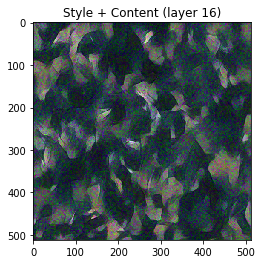

In [93]:
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)




# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=1000,content_layers=['conv_16'])

plt.figure()
imshow(output, title='Style + Content (layer 16)')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Invariances

In [26]:

# def get_invariance_optimizer(input_img):
#     # this line to show that input is a parameter that requires a gradient
#     optimizer = optim.LBFGS([input_img.requires_grad_()])
#     return optimizer

def get_invariance_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()],lr =.01)
    return optimizer

In [27]:
import numpy as np

class DiffLoss(nn.Module):

    def __init__(self, target,normalize=True,vectorize = False, target_feature_id = None):
        super(DiffLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.normalize = normalize
        #import pdb;pdb.set_trace()
        self.target_feature_id = target_feature_id
        if len(target.shape) == 3:
            self.vectorize = True
        else:
            self.vectorize = vectorize
        self.target = target.detach()
        #self.normalize = normalize

    def forward(self, input):
        #print('Content Loss')
        #print('target shape: %s'%str(self.target.shape))
        #print('input shape: %s'%str(input.shape))
        #self.loss = F.mse_loss(input, self.target)
        #import pdb;pdb.set_trace()
        self.lossf = torch.nn.CosineSimilarity()
        #print(self.target.shape)
        if self.vectorize:
            self.target_flat = torch.flatten(self.target, start_dim=1)
            if self.target_feature_id is None:
                flat_input = torch.flatten(input, start_dim=1)
            else:
                #print('Got Here!')
                flat_input = torch.flatten(input[:,self.target_feature_id,:,:], start_dim=1)
            self.loss = self.lossf(flat_input,self.target_flat)
        else:
            self.loss = self.lossf(input,self.target)
            self.loss = torch.mean(self.loss)
        #if self.normalize:
        #    self.loss = self.loss/np.sqrt(torch.numel(input))*1000
        return input

In [28]:
# desired depth layers to compute style/content losses :
same_layers_default = ['conv_4']
diff_layers_default = ['conv_1']

def get_invariance_model_and_losses(cnn, normalization_mean, normalization_std, target_img,
                                   same_layers=same_layers_default,diff_layers=diff_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    same_losses = []
    diff_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    
    #pixel input losses
    if 'pixel' in same_layers:
        # add sameness loss:
        target = model(target_img).detach()
        same_loss = DiffLoss(target)
        model.add_module("same_loss_pixel", same_loss)
        same_losses.append(same_loss)
        
    if 'pixel' in diff_layers:
        # add sameness loss:
        target = model(target_img).detach()
        diff_loss = DiffLoss(target)
        model.add_module("diff_loss_pixel", diff_loss)
        diff_losses.append(diff_loss)
    
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        
        for same_layer in same_layers:
            if name in same_layer:
                # add sameness loss:
                if ':' not in same_layer:
                    target = model(target_img).detach()
                    same_loss = DiffLoss(target)
                else:
                    feature = int(same_layer.split(':')[-1])
                    target = model(target_img)[:,feature,:,:].detach()
                    same_loss = DiffLoss(target,target_feature_id = feature)
                
                model.add_module("same_loss_{}".format(name), same_loss)
                same_losses.append(same_loss)
                
        for diff_layer in diff_layers:
            if name in diff_layer:
                # add difference loss:
                if ':' not in diff_layer:
                    target = model(target_img).detach()
                    diff_loss = DiffLoss(target)
                else:
                    feature = int(diff_layer.split(':')[-1])
                    target = model(target_img)[:,feature,:,:].detach()
                    diff_loss = DiffLoss(target,target_feature_id=feature)

                model.add_module("diff_loss_{}".format(name), diff_loss)
                diff_losses.append(diff_loss)
        

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], DiffLoss):
            break

    model = model[:(i + 1)]

    return model, same_losses, diff_losses

In [40]:
from copy import deepcopy

def run_invariant_image(cnn, normalization_mean, normalization_std,
                       target_img, input_img, num_steps=300,
                       same_weight=1, diff_weight=1,
                       diff_layers = diff_layers_default,same_layers=same_layers_default,orthog=False):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, same_losses, diff_losses = get_invariance_model_and_losses(cnn,
        normalization_mean, normalization_std, target_img, 
        same_layers = same_layers, diff_layers = diff_layers)
    optimizer = get_invariance_optimizer(input_img)

    
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            diff_score = 0
            same_score = 0
            
            for dl in diff_losses:
                if orthog:
                    diff_score += torch.abs(dl.loss)
                else:
                    diff_score += dl.loss
            for sl in same_losses:
                same_score += sl.loss

            diff_score *= diff_weight
            same_score *= same_weight
            
            
            #below is really what you have to mess with
            loss = diff_score - same_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0 or run[0] == 1:
                print("run {}:".format(run))
                print('Diff Loss : {:4f} Same Loss: {:4f}'.format(
                    diff_score.item(), same_score.item()))
                print()

            return diff_score-same_score

        optimizer.step(closure)
        #if run[0] % 50 == 0:
        #    plt.figure()
        #    imshow(input_img)

        #    plt.ioff()
        #    plt.show()
            

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

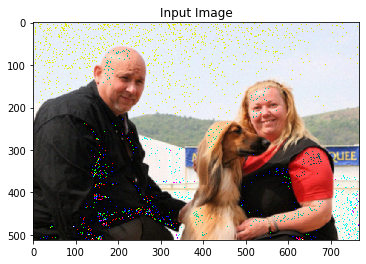

Building the style transfer model..
Optimizing..
run [1]:
Diff Loss : 0.791894 Same Loss: 0.943725



/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Diff Loss : -0.033324 Same Loss: 0.998248

run [100]:
Diff Loss : -0.152059 Same Loss: 0.997384

run [150]:
Diff Loss : -0.204306 Same Loss: 0.999198

run [200]:
Diff Loss : -0.233460 Same Loss: 0.999409

run [250]:
Diff Loss : -0.249453 Same Loss: 0.998715

run [300]:
Diff Loss : -0.268283 Same Loss: 0.999575



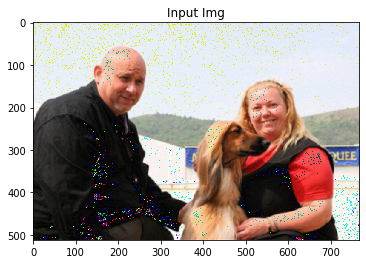

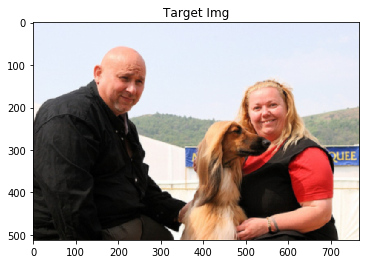

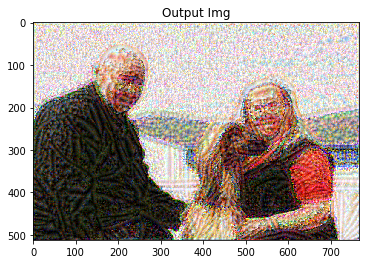

In [53]:
# if you want to use white noise instead uncomment the below line:
image_name = '../cnn_subgraph_visualizer/image_data/imagenet_50/input_images/Afghan_hound_10.JPEG'
content_img = image_loader(image_name)
#input_img = torch.randn(content_img.data.size(), device=device)
input_img = content_img.clone() + torch.randn(content_img.data.size(), device=device)*.01
#input_img = content_img.clone()
target_img = content_img.clone()
#target_img = torch.randn(content_img.data.size(), device=device)


# add the original input image to the figure:

plt.figure()
imshow(input_img, title='Input Image')


output = run_invariant_image(cnn, cnn_normalization_mean, cnn_normalization_std,
                            target_img, deepcopy(input_img),
                             num_steps=300,
                             diff_layers = ['conv_4'],
                             same_layers = ['conv_5:5'],
                            same_weight=1)

plt.figure()
imshow(input_img,'Input Img')

plt.figure()
imshow(target_img,'Target Img')

plt.figure()
imshow(output,'Output Img')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:




# if you want to use white noise instead uncomment the below line:
image_name = '../cnn_subgraph_visualizer/image_data/imagenet_50/input_images/Afghan_hound_10.JPEG'
content_img = image_loader(image_name)
#input_img = torch.randn(content_img.data.size(), device=device)
input_img = content_img.clone() + torch.randn(content_img.data.size(), device=device)*.01
#input_img = content_img.clone()
target_img = content_img.clone()
#target_img = torch.randn(content_img.data.size(), device=device)


# add the original input image to the figure:

plt.figure()
imshow(input_img, title='Input Image')


output = run_invariant_image(cnn, cnn_normalization_mean, cnn_normalization_std,
                            target_img, deepcopy(input_img),
                             num_steps=300,
                             diff_layers = ['conv_4'],
                             same_layers = ['conv_5:5'],
                            same_weight=1)

plt.figure()
imshow(input_img,'Input Img')

plt.figure()
imshow(target_img,'Target Img')

plt.figure()
imshow(output,'Output Img')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [77]:
x=torch.randn(content_img.data.size(), device=device)
y = torch.flatten(x, start_dim=1)
y.shape

torch.Size([1, 786432])

In [78]:
x.shape

torch.Size([1, 3, 512, 512])

In [79]:
3*512*512

786432